In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib

In [3]:
import os
import logging
import argparse
import glob
import json

import numpy as np
from matplotlib.ticker import StrMethodFormatter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u
from sklearn.metrics import confusion_matrix, roc_curve
from PIL import Image
from scipy.stats import binom
from IPython.display import display, Markdown

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config
from zoobot.active_learning import acquisition_utils

import tensorflow_probability as tfp

In [4]:
os.chdir('/home/walml/repos/zoobot')

In [5]:
label_cols = [
    'smooth-or-featured_smooth',
    'smooth-or-featured_featured-or-disk',
    'has-spiral-arms_yes',
    'has-spiral-arms_no',
#     'spiral-winding_tight',
#     'spiral-winding_medium',
#     'spiral-winding_loose',
    'bar_strong',
    'bar_weak',
    'bar_no',
    'bulge-size_dominant',
    'bulge-size_large',
    'bulge-size_moderate',
    'bulge-size_small',
    'bulge-size_none'
]

questions = [
    'smooth-or-featured',
    'has-spiral-arms',
#     'spiral-winding',
    'bar',
    'bulge-size'
]

schema = losses.Schema(label_cols, questions, version='decals')
schema.questions

{smooth-or-featured, indices 0 to 1, asked after None: (0, 1), has-spiral-arms, indices 2 to 3, asked after <zoobot.estimators.losses.Answer object at 0x7fece0055c10>: (2, 3), bar, indices 4 to 6, asked after <zoobot.estimators.losses.Answer object at 0x7fece0055c10>: (4, 6), bulge-size, indices 7 to 11, asked after <zoobot.estimators.losses.Answer object at 0x7fece0055c10>: (7, 11)}


[smooth-or-featured, indices 0 to 1, asked after None,
 has-spiral-arms, indices 2 to 3, asked after <zoobot.estimators.losses.Answer object at 0x7fece0055c10>,
 bar, indices 4 to 6, asked after <zoobot.estimators.losses.Answer object at 0x7fece0055c10>,
 bulge-size, indices 7 to 11, asked after <zoobot.estimators.losses.Answer object at 0x7fece0055c10>]

In [6]:
# df = pd.read_csv('temp/master_256_predictions_2500init.csv')
# df = pd.read_csv('temp/smooth_or_featured_labelled_latest.csv')
df = pd.read_csv('temp/dirichlet_concentrations.csv')

In [7]:
for col in label_cols:
    prediction_col = col + '_concentration'
    df[prediction_col] = df[prediction_col].apply(json.loads)

In [8]:
permutations = acquisition_utils.get_discrete_permutations(10, 3)
np.array(list(permutations))[:10]

array([[10,  0,  0],
       [ 9,  1,  0],
       [ 9,  0,  1],
       [ 8,  2,  0],
       [ 8,  1,  1],
       [ 8,  0,  2],
       [ 7,  3,  0],
       [ 7,  2,  1],
       [ 7,  1,  2],
       [ 7,  0,  3]])

## Check dirichlet_mixture

In [9]:
n_galaxies = 5
n_answers = 2
n_samples = 2
concentration_per_g = np.array([[2., 2.], [2., 2.]])
concentration = tf.constant(np.stack([concentration_per_g] * n_galaxies, axis=0), dtype=tf.float32)
concentration.shape

TensorShape([5, 2, 2])

In [10]:
expected_votes = tf.constant(10, dtype=tf.float32)

In [11]:
mixture = acquisition_utils.dirichlet_mixture(concentration, expected_votes, n_samples)
print(mixture)
print(mixture.sample())
print(mixture.prob(mixture.sample()))

tfp.distributions.MixtureSameFamily("MixtureSameFamily", batch_shape=[5], event_shape=[2], dtype=float32)
tf.Tensor(
[[6. 4.]
 [9. 1.]
 [5. 5.]
 [6. 4.]
 [5. 5.]], shape=(5, 2), dtype=float32)
tf.Tensor([0.09440558 0.11188798 0.06992995 0.12587404 0.09440558], shape=(5,), dtype=float32)


## Check dirichlet_prob_of_answers

In [12]:

samples = np.array([df[a.text + '_concentration'] for a in schema.answers]).transpose(1, 0, 2)

In [13]:
p_of_answers = acquisition_utils.dirichlet_prob_of_answers(tf.constant(samples, dtype=tf.float32), schema)
p_of_answers.shape

(1000, 12)

In [14]:
p_of_answers[:10, 0]

array([0.21489806, 0.2426738 , 0.19346699, 0.11390952, 0.10634384,
       0.27155057, 0.2620096 , 0.17210558, 0.07060944, 0.18537442],
      dtype=float32)

In [15]:
p_of_answers[:10, 1]

array([0.78510195, 0.7573263 , 0.806533  , 0.8860905 , 0.89365625,
       0.72844946, 0.7379904 , 0.8278945 , 0.92939067, 0.8146257 ],
      dtype=float32)

## Check entropy_in_permutations

In [16]:
total_votes = tf.constant(10, dtype=tf.float32)
question = schema.get_question('has-spiral-arms')
samples_for_q = tf.constant(samples[:1, question.start_index:question.end_index+1, 0], dtype=tf.float32)
print(samples_for_q.shape)

(1, 2)


In [17]:
dist = tfp.distributions.DirichletMultinomial(total_votes, samples_for_q)
print(dist)
acquisition_utils.entropy_in_permutations_by_galaxy(dist, int(total_votes.numpy()), n_answers)

tfp.distributions.DirichletMultinomial("DirichletMultinomial", batch_shape=[1], event_shape=[2], dtype=float32)


2.302142

In [18]:
samples_for_q = tf.constant(samples[:1, question.start_index:question.end_index+1, :], dtype=tf.float32)
print(samples_for_q.shape)
n_samples = samples_for_q.shape[2]

dist = acquisition_utils.dirichlet_mixture(samples_for_q, total_votes, n_samples)
print(dist)
acquisition_utils.entropy_in_permutations_by_galaxy(dist, int(total_votes.numpy()), n_answers)

(1, 2, 15)
tfp.distributions.MixtureSameFamily("MixtureSameFamily", batch_shape=[1], event_shape=[2], dtype=float32)


2.2240295

In [19]:
dist.batch_shape

TensorShape([1])

In [20]:
tf.TensorShape((2, 4))

TensorShape([2, 4])

## Check entropy per model

In [21]:
samples_for_q = tf.constant(samples[:32, question.start_index:question.end_index+1, :], dtype=tf.float32)

In [22]:
expected_votes=np.random.randint(low=5, high=10, size=len(samples_for_q)).astype(np.float32)

In [23]:
expected_entropies = acquisition_utils.dirichlet_expected_entropy_per_model(samples_for_q, expected_votes)
expected_entropies.shape, expected_entropies

((32,),
 array([1.6384524 , 1.8163879 , 1.0429956 , 0.87863106, 1.3975656 ,
        1.6583021 , 1.0782206 , 1.4095253 , 0.49897665, 1.2751144 ,
        1.9305024 , 1.9938865 , 1.7167026 , 0.68897444, 1.7632272 ,
        1.6393307 , 1.9330472 , 1.2764195 , 1.2850144 , 1.6859621 ,
        0.7403629 , 1.1376289 , 1.5202172 , 0.93313503, 1.4237555 ,
        1.2885422 , 0.702355  , 1.4261619 , 1.7600121 , 2.1393878 ,
        1.3123282 , 1.1899185 ], dtype=float32))

In [24]:
expected_entropies = acquisition_utils.dirichlet_predictive_entropy_per_model(samples_for_q, expected_votes)
expected_entropies.shape, expected_entropies

((32,),
 array([1.6447492 , 1.8296053 , 1.0529093 , 0.8828681 , 1.4133464 ,
        1.6868198 , 1.0834298 , 1.4355438 , 0.5022089 , 1.2835559 ,
        1.9451661 , 2.0053363 , 1.728374  , 0.6947184 , 1.7742746 ,
        1.6632261 , 1.9516696 , 1.284523  , 1.2952497 , 1.6916264 ,
        0.7442594 , 1.1556466 , 1.5390816 , 0.9436223 , 1.4384245 ,
        1.2986957 , 0.72627884, 1.4349462 , 1.7731798 , 2.153853  ,
        1.3354999 , 1.2082552 ], dtype=float32))

## Check multi-model predictive and expected entropy

In [26]:
def plot_pdf(model_a_conc, model_b_conc, ax=None):

    if ax==None:
        fig, ax = plt.subplots(figsize=(8, 6))

    all_log_probs = []
    for d in range(n_samples):
        concentrations = tf.constant(model_a_conc[0, :, d].astype(np.float32))
        log_probs = tfp.distributions.DirichletMultinomial(total_votes, concentrations).prob(x)
        all_log_probs.append(log_probs)
        ax.plot(votes, log_probs, alpha=.2, color='b')
    all_log_probs = np.array(all_log_probs).mean(axis=0)
    ax.plot(votes, all_log_probs, linewidth=3., color='b')
    
    all_log_probs = []
    for d in range(n_samples):
        concentrations = tf.constant(model_b_conc[0, :, d].astype(np.float32))
        log_probs = tfp.distributions.DirichletMultinomial(total_votes, concentrations).prob(x)
        all_log_probs.append(log_probs)
        ax.plot(votes, log_probs, alpha=.2, color='r')
    all_log_probs = np.array(all_log_probs).mean(axis=0)
    ax.plot(votes, all_log_probs, linewidth=3., color='r')
    
    # ax.axvline(votes_this_answer, color='r')
    ax.set_xlim(0., total_votes)
#     fig.tight_layout()

In [27]:
# both concentrations similar -> symmetry
# one high, one low -> pdf towards the high
# size of both concentrations -> strength of effect

In [28]:
n_samples = 15

conc_shape = (1, 2, n_samples)

model_a_concentrations = np.ones(conc_shape) * 1. + np.random.rand(*conc_shape) * 0.2
model_b_concentrations = model_a_concentrations.copy()

# strong agreement - do nothing

# strong disagreement
# 2.18 expected, 2.32 predictive -> 0.14
model_a_concentrations[:, 0] = 90
model_a_concentrations[:, 1] = 10


# for low dropout, per-model expected and per-model predictive are very similar
# multi-model expected will be a simple average of per-model expected
# multi-model predictive will be much higher if the models disagree confidently, low if they agree or are uncertain

# expected 2.18, predictive 2.4-> 
# both uncertain, strong agreement - low MI as expected
# 2.4 -> ~0
# model_a_concentrations = np.ones(conc_shape) + np.random.rand(*conc_shape) * 0.05
# model_b_concentrations = np.ones(conc_shape) + np.random.rand(*conc_shape) * 0.05

# one uncertain, one confident
# 2.4, 2.18 -> 0.06
# model_a_concentrations = np.ones(conc_shape) + np.random.rand(*conc_shape) * 0.05
# model_b_concentrations[:, 0] = 1.5

model_a_concentrations = model_a_concentrations.astype(np.float32)
model_b_concentrations = model_b_concentrations.astype(np.float32)

total_votes = np.array([10.]).astype(np.float32)  # all entropy measurements get higher with more total votes, perhaps as expected. This effect is much bigger than predictive vs expected, but affects both - what happens to the subtraction?
# subtraction is a little higher for 10x votes, but quite similar. Good stuff.
votes = np.linspace(0., total_votes)
x = np.stack([votes, total_votes-votes], axis=-1)  # also need the counts for other answer, no
# votes_this_answer = 4


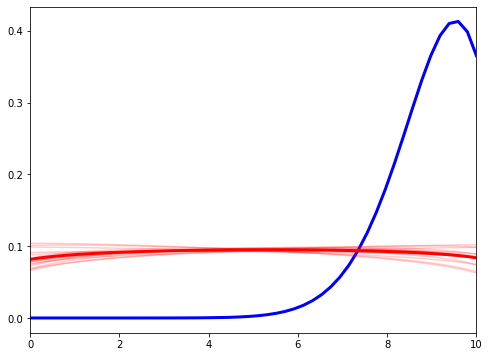

In [29]:
plot_pdf(model_a_concentrations, model_b_concentrations)

In [30]:
acquisition_utils.dirichlet_expected_entropy_per_model(model_a_concentrations, total_votes), acquisition_utils.dirichlet_expected_entropy_per_model(model_b_concentrations, total_votes) # mean entropy of dropout samples of each model
# bothers me that these are so similar for very certain vs very uncertain!

(array([1.3005123], dtype=float32), array([2.39397], dtype=float32))

In [31]:
# joint_samples = np.concatenate([model_a_concentrations, model_b_concentrations], axis=-1)
# acquisition_utils.dirichlet_expected_entropy_per_model(joint_samples, total_votes)  # mean entropy of all dropout samples, will be somewhere between the above

In [32]:
expected = acquisition_utils.dirichlet_expected_entropy([model_a_concentrations, model_b_concentrations], [total_votes, total_votes])  # entropy marginalised over all models, should be higher where models disagree
expected

array([1.8486176], dtype=float32)

In [33]:
# acquisition_utils.dirichlet_predictive_entropy_per_model(model_a_concentrations, total_votes), acquisition_utils.dirichlet_predictive_entropy_per_model(model_b_concentrations, total_votes) # entropy marginalised over dropouts, should be very similar to expected for small dropout variation

In [34]:
# acquisition_utils.dirichlet_predictive_entropy_per_model(joint_samples, total_votes)  # entropy marginalised over all models, should be higher where models disagree

In [35]:
predictive = acquisition_utils.dirichlet_predictive_entropy([model_a_concentrations, model_b_concentrations], [total_votes, total_votes])  # entropy marginalised over all models, should be higher where models disagree
predictive

array([2.1505024], dtype=float32)

In [36]:
predictive - expected

array([0.3018849], dtype=float32)

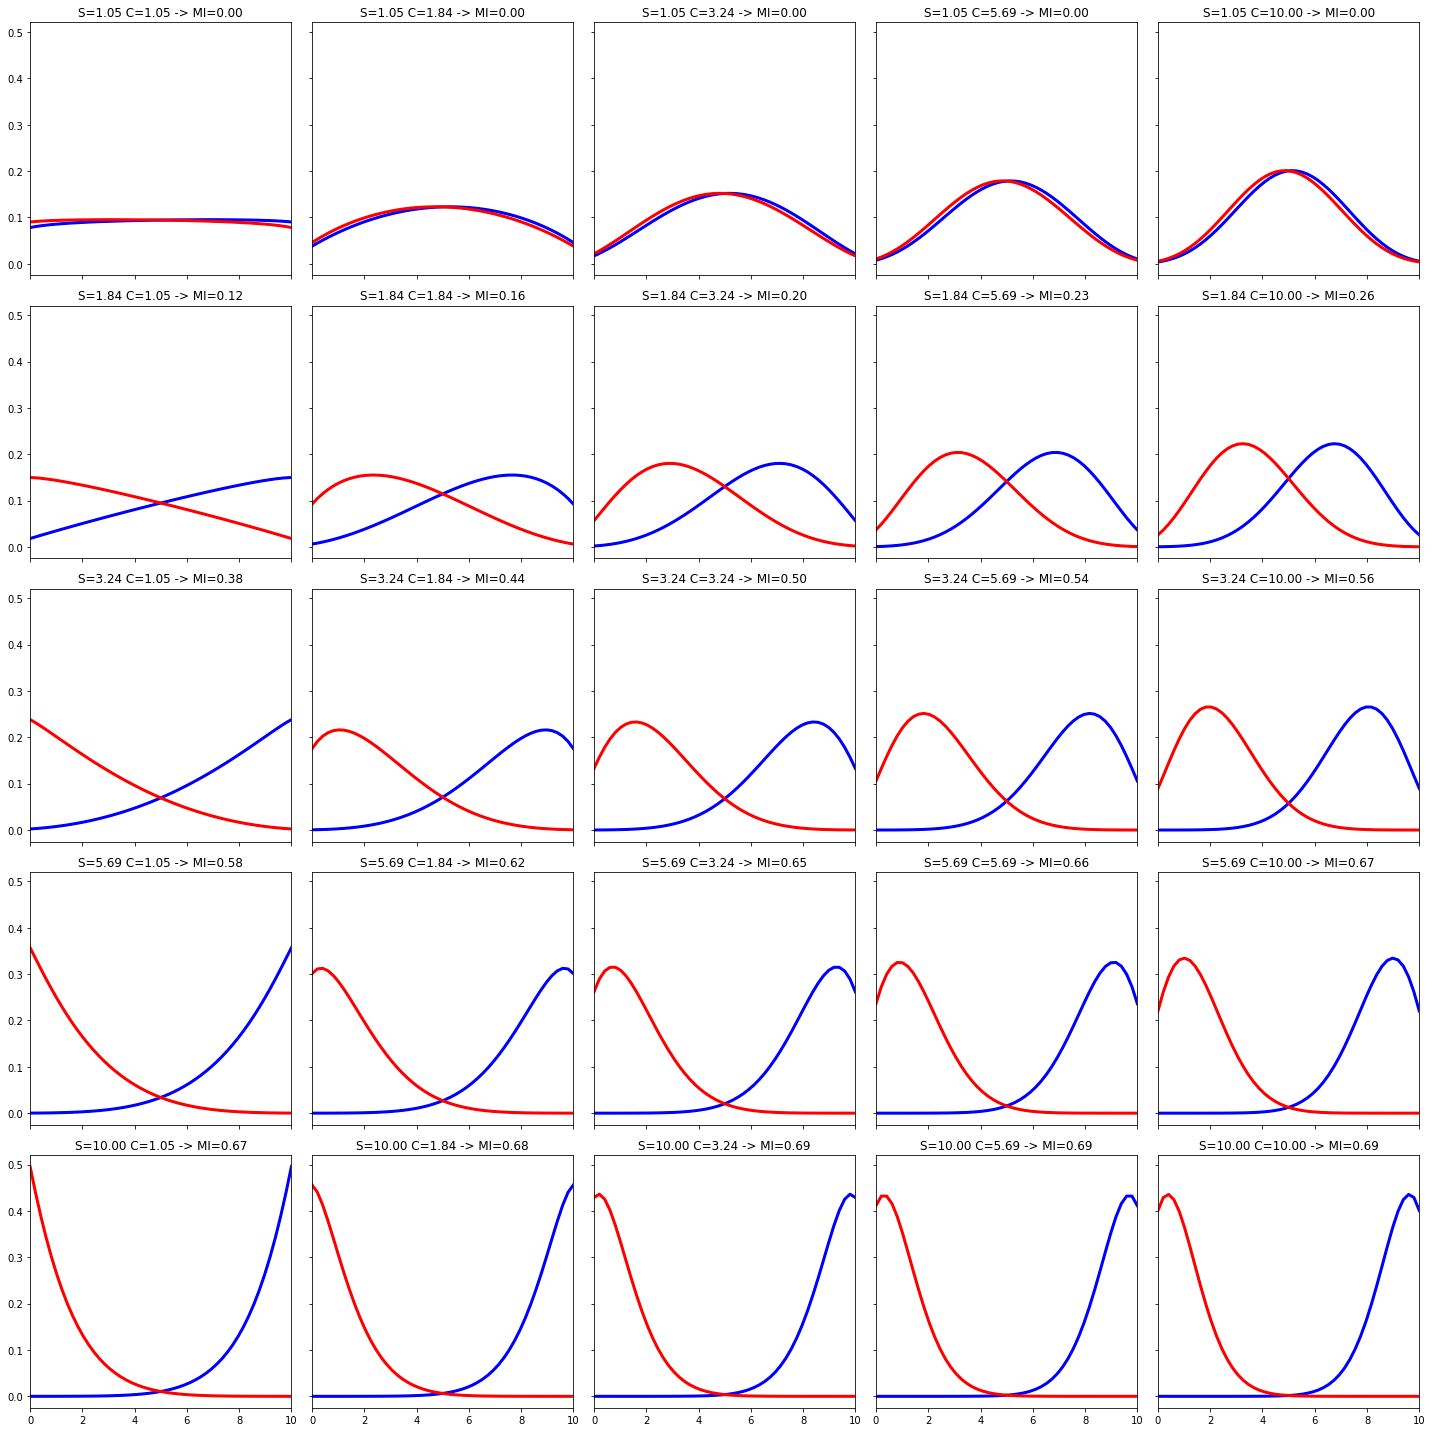

In [37]:

# skew_var = 1
# confidence_var = 200

expected = []
predictive = []
skew = []
confidence = []

num = 50
# skew_vars = np.linspace(1., 10, num=num)
skew_vars = np.logspace(np.log10(1), np.log10(10), num=num)
confidence_vars = np.logspace(np.log10(1), np.log10(10), num=num)

n_viz = 4
fig, axes = plt.subplots(nrows=n_viz+1, ncols=n_viz+1, figsize=(20, 20), sharex=True, sharey=True)

interval = int(num / n_viz)
good_n = np.arange(1, num, interval)

for n_skew, skew_var in enumerate(skew_vars):
    for n_conf, confidence_var in enumerate(confidence_vars):

        model_a_concentrations[:, 0] = skew_var * confidence_var
        model_a_concentrations[:, 1] = 1 * confidence_var

        model_b_concentrations[:, 0] = model_a_concentrations[:, 1]
        model_b_concentrations[:, 1] = model_a_concentrations[:, 0]

        model_a_concentrations = model_a_concentrations.astype(np.float32)
        model_b_concentrations = model_b_concentrations.astype(np.float32)

        expected.append(float(acquisition_utils.dirichlet_expected_entropy([model_a_concentrations, model_b_concentrations], [total_votes, total_votes])))
        predictive.append(float(acquisition_utils.dirichlet_predictive_entropy([model_a_concentrations, model_b_concentrations], [total_votes, total_votes])))
        skew.append(skew_var)
        confidence.append(confidence_var)
        
        if n_skew in good_n and n_conf in good_n:
            row = int(np.argwhere(good_n == n_skew))
            col = int(np.argwhere(good_n == n_conf))
            ax = axes[row, col]
            plot_pdf(model_a_concentrations, model_b_concentrations, ax=ax)
            ax.set_title('S={:.2f} C={:.2f} -> MI={:.2f}'.format(skew_var, confidence_var, predictive[-1] - expected[-1]))
            
fig.tight_layout()


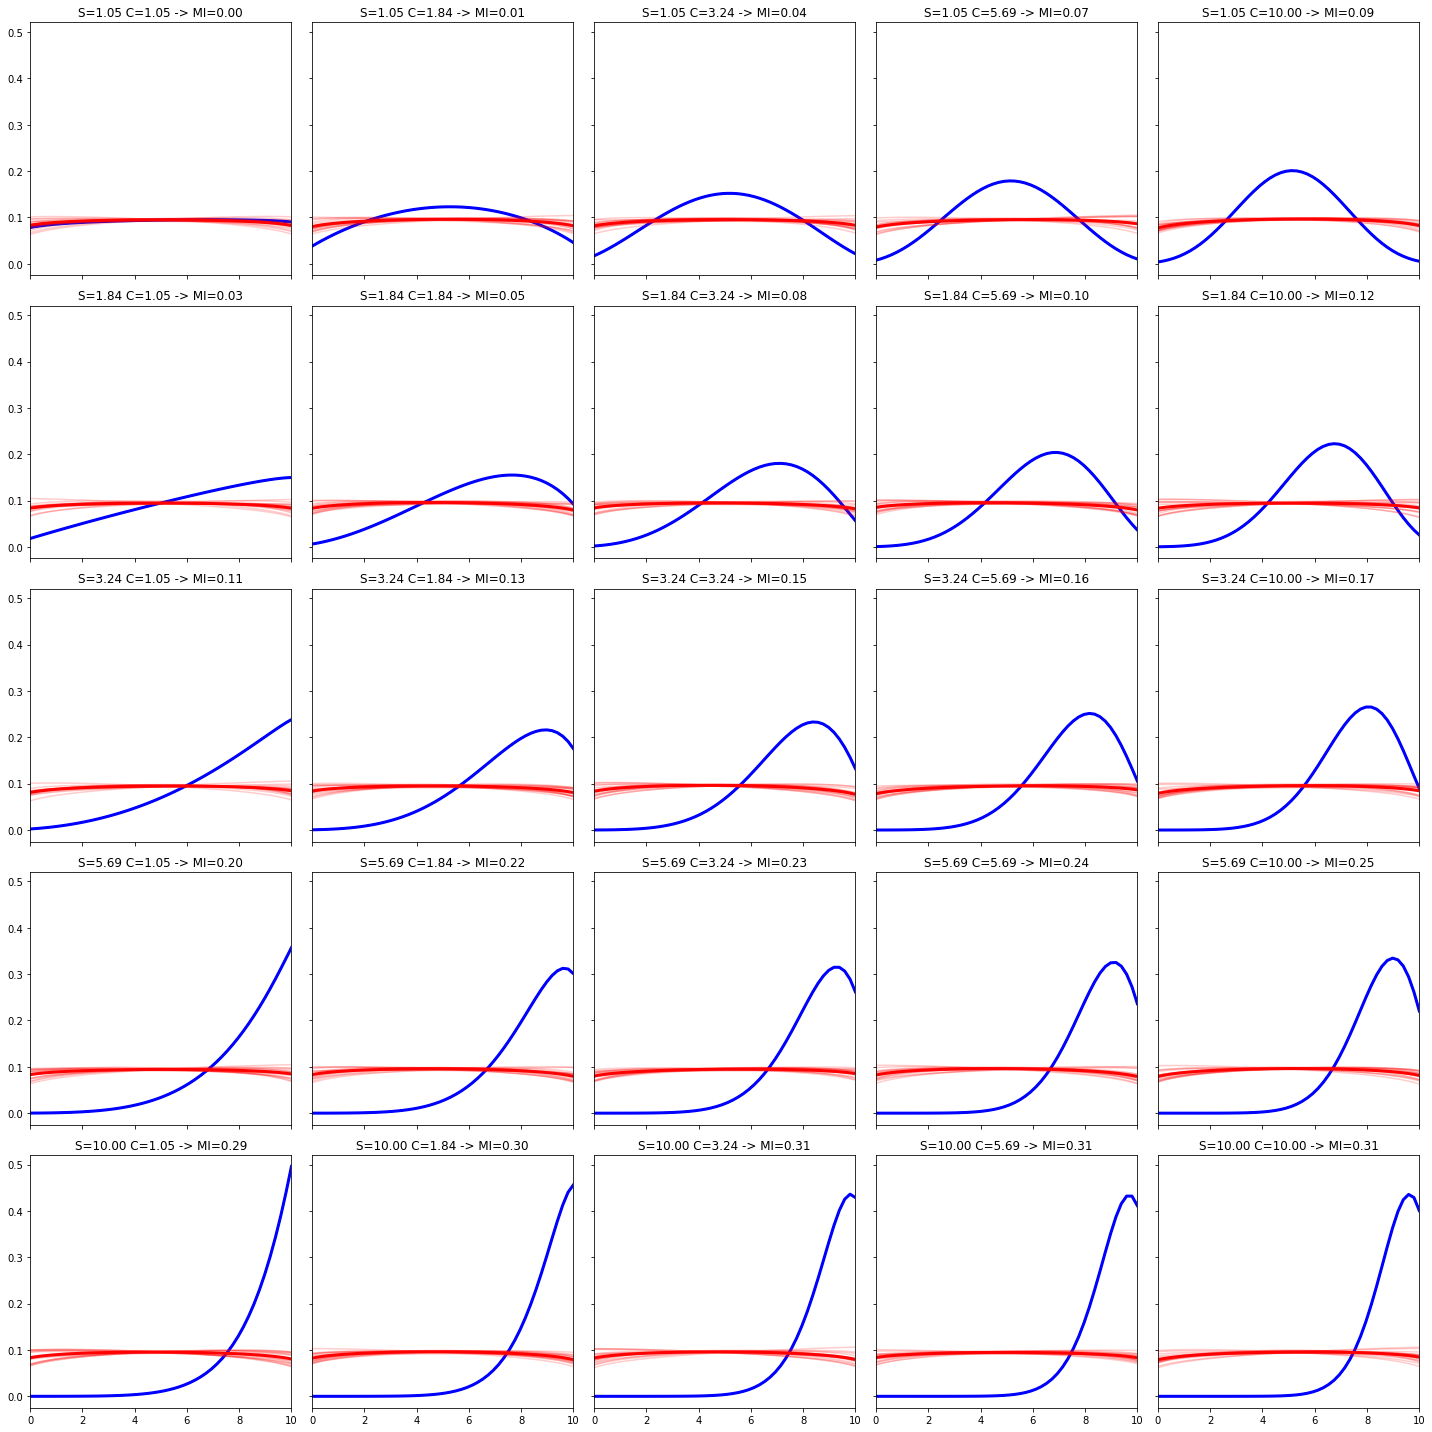

In [38]:

# skew_var = 1
# confidence_var = 200

expected = []
predictive = []
skew = []
confidence = []

num = 50
# skew_vars = np.linspace(1., 10, num=num)
skew_vars = np.logspace(np.log10(1), np.log10(10), num=num)
confidence_vars = np.logspace(np.log10(1), np.log10(10), num=num)

n_viz = 4
fig, axes = plt.subplots(nrows=n_viz+1, ncols=n_viz+1, figsize=(20, 20), sharex=True, sharey=True)

interval = int(num / n_viz)
good_n = np.arange(1, num, interval)

for n_skew, skew_var in enumerate(skew_vars):
    for n_conf, confidence_var in enumerate(confidence_vars):

        model_a_concentrations[:, 0] = skew_var * confidence_var
        model_a_concentrations[:, 1] = 1 * confidence_var

        model_b_concentrations =  np.ones(conc_shape) * 1. + np.random.rand(*conc_shape) * 0.2  # uncertain

        model_a_concentrations = model_a_concentrations.astype(np.float32)
        model_b_concentrations = model_b_concentrations.astype(np.float32)

        expected.append(float(acquisition_utils.dirichlet_expected_entropy([model_a_concentrations, model_b_concentrations], [total_votes, total_votes])))
        predictive.append(float(acquisition_utils.dirichlet_predictive_entropy([model_a_concentrations, model_b_concentrations], [total_votes, total_votes])))
        skew.append(skew_var)
        confidence.append(confidence_var)
        
        if n_skew in good_n and n_conf in good_n:
            row = int(np.argwhere(good_n == n_skew))
            col = int(np.argwhere(good_n == n_conf))
            ax = axes[row, col]
            plot_pdf(model_a_concentrations, model_b_concentrations, ax=ax)
            ax.set_title('S={:.2f} C={:.2f} -> MI={:.2f}'.format(skew_var, confidence_var, predictive[-1] - expected[-1]))
            
fig.tight_layout()


In [39]:
data = np.array([expected, predictive, skew, confidence])
data.shape

(4, 2500)

In [40]:
results = pd.DataFrame(data=np.array([expected, predictive, skew, confidence]).transpose(), columns=['expected', 'predictive', 'skew', 'confidence'])
results['mutual'] = results['predictive'] - results['expected']

Text(0.5, 1.0, 'predictive')

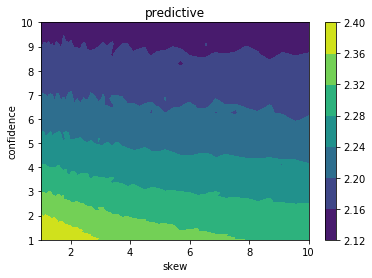

In [41]:
plt.contourf(skew_vars, confidence_vars, results['predictive'].values.reshape(num, num))
plt.colorbar()
plt.xlabel('skew')
plt.ylabel('confidence')
plt.title('predictive')

Text(0.5, 1.0, 'expected')

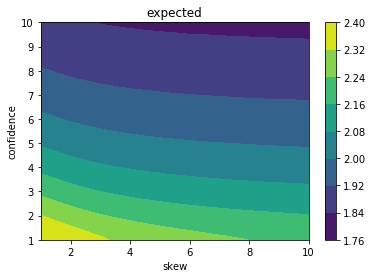

In [42]:
plt.contourf(skew_vars, confidence_vars, results['expected'].values.reshape(num, num))
plt.colorbar()
plt.xlabel('skew')
plt.ylabel('confidence')
plt.title('expected')

Text(0.5, 1.0, 'mutual')

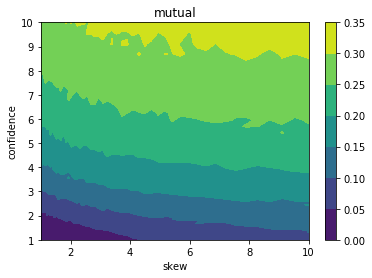

In [43]:
plt.contourf(skew_vars, confidence_vars, results['mutual'].values.reshape(num, num))
plt.colorbar()
plt.xlabel('skew')
plt.ylabel('confidence')
plt.title('mutual')

In [ ]:
## TODO check get_multimodel_acq for assumed samples

## Check dirichlet_mutual_information

In [ ]:
samples_for_q_a = tf.identity(samples_for_q)
samples_for_q_b = samples_for_q + tf.random.uniform(shape=samples_for_q_a.shape)
list_of_samples_for_q = [samples_for_q_a, samples_for_q_b]

expected_votes_a = tf.identity(expected_votes)
expected_votes_b = tf.identity(expected_votes) + tf.constant(2.)
list_of_expected_votes = [expected_votes_a, expected_votes_b]

In [ ]:
acquisition_utils.dirichlet_expected_entropy(list_of_samples_for_q, list_of_expected_votes)

In [ ]:
print(expected_votes_a, expected_votes_b)

In [ ]:
acquisition_utils.dirichlet_predictive_entropy(list_of_samples_for_q, list_of_expected_votes)

## and all together...

In [ ]:
samples_a = tf.identity(tf.constant(samples[:32], dtype=tf.float32))
samples_b = samples[:32] + tf.random.uniform(shape=samples_a.shape)
list_of_samples_for_q = [samples_a, samples_b]

entropy, predictive, expected = acquisition_utils.get_multimodel_acq(list_of_samples_for_q, schema)

# much slower for 4 answers then 3, 5 perhaps too slow. Simple fix: group large/dominant bulge

In [ ]:
entropy.shape

In [ ]:
entropy

In [ ]:
np.log10(entropy)

In [ ]:
fig, axes = plt.subplots(nrows=len(schema.questions), sharex=True)
for n in range(len(schema.questions)):
    ax = axes[n]
    ax.hist(np.log10(entropy[:, n]))
fig.tight_layout()

In [ ]:
question = schema.get_question('has-spiral-arms')
answer = question.answers[0]

In [ ]:
n = 0

galaxy = df.iloc[n]
total_votes = int(galaxy[question.text+'_total-votes'])

votes = np.linspace(0., total_votes)
x = np.stack([votes, total_votes-votes], axis=-1)  # also need the counts for other answer, no
votes_this_answer = x[:, answer.index - question.start_index]




In [ ]:

fig, ax = plt.subplots()

answer = question.answers[0]

all_log_probs = []
for d in range(15):
    concentrations = tf.constant(samples_for_q[n, :, d], dtype=tf.float32)
    log_probs = tfp.distributions.DirichletMultinomial(tf.constant(total_votes, dtype=tf.float32), concentrations).prob(x)
    all_log_probs.append(log_probs)
    ax.plot(votes_this_answer, log_probs, alpha=.2, color='k')
    
ax.plot(votes_this_answer, np.mean(all_log_probs, axis=0), linewidth=3.)
